# Unit12 支持向量分類 | Support Vector Classification (SVC)

本 Notebook 使用模擬化學反應數據建立支持向量分類模型來預測反應成功與否。

## 目標
- 理解支持向量機 (SVM) 的核心概念
- 比較不同核函數 (Linear, RBF, Polynomial) 的效果
- 掌握超參數調整 (C, gamma)
- 應用於化工領域分類問題

**課程代碼**: CHE-AI-114  
**單位**: 逢甲大學化學工程學系  
**教師**: 莊曜禎 助理教授

---
## 0. 環境設定

In [41]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit12_Support_Vector_Classification'
SOURCE_DATA_DIR = 'simulated_reaction_data'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit12'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\data\simulated_reaction_data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [42]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, accuracy_score
)

# 設定全局參數
SEED = 42
np.random.seed(SEED)

# 設定 matplotlib 參數
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("✓ 套件載入完成")
print(f"✓ 隨機種子: {SEED}")

✓ 套件載入完成
✓ 隨機種子: 42


---
## 2. 數據生成與探索

In [43]:
# 生成模擬化學反應數據（具有非線性關係）
n_samples = 500

# 生成特徵
temperature = np.random.uniform(150, 250, n_samples)
pressure = np.random.uniform(5, 30, n_samples)
catalyst_concentration = np.random.uniform(0.01, 0.1, n_samples)
reactant_ratio = np.random.uniform(1.0, 3.0, n_samples)
reaction_time = np.random.uniform(2, 10, n_samples)

# 生成非線性目標變數
linear_comb = (
    0.05 * (temperature - 200) +
    0.15 * (pressure - 15) +
    50 * (catalyst_concentration - 0.055) +
    0.8 * (reactant_ratio - 2.0) +
    0.3 * (reaction_time - 6)
)

nonlinear_comb = (
    0.001 * (temperature - 200)**2 +
    0.01 * (pressure - 15)**2 +
    500 * (catalyst_concentration - 0.055)**2 +
    0.1 * (reactant_ratio - 2.0) * (pressure - 15) +
    np.random.normal(0, 2, n_samples)
)

total_score = linear_comb + nonlinear_comb
probability = 1 / (1 + np.exp(-total_score))
success = (probability > 0.5).astype(int)

# 創建 DataFrame
df = pd.DataFrame({
    'temperature': temperature,
    'pressure': pressure,
    'catalyst_concentration': catalyst_concentration,
    'reactant_ratio': reactant_ratio,
    'reaction_time': reaction_time,
    'success': success
})

print("="*60)
print("數據集概覽")
print("="*60)
print(df.head(10))
print(f"\n數據集形狀: {df.shape}")
print(f"\n類別分佈:")
print(df['success'].value_counts())
print(f"成功率: {df['success'].mean():.2%}")

數據集概覽
   temperature   pressure  catalyst_concentration  reactant_ratio  \
0   187.454012  22.454043                0.026662        2.038164   
1   245.071431  18.402409                0.058771        1.958364   
2   223.199394  12.738190                0.088565        1.051284   
3   209.865848  25.344875                0.075900        1.682496   
4   165.601864  22.118279                0.082591        1.760391   
5   165.599452   9.065423                0.069291        1.797646   
6   155.808361  27.773180                0.072305        2.160345   
7   236.617615  25.563431                0.086428        2.067205   
8   210.111501  28.744998                0.032470        2.215810   
9   220.807258  23.142988                0.054048        2.529767   

   reaction_time  success  
0       4.093645        1  
1       3.975830        1  
2       9.250037        1  
3       3.996370        1  
4       4.175598        1  
5       8.075186        1  
6       5.597919        1  
7       8.

In [44]:
# 統計摘要
print("\n" + "="*60)
print("統計摘要")
print("="*60)
print(df.describe())


統計摘要
       temperature    pressure  catalyst_concentration  reactant_ratio  \
count   500.000000  500.000000              500.000000      500.000000   
mean    199.856171   17.048785                0.056580        1.992953   
std      29.868841    7.137336                0.026747        0.574020   
min     150.506158    5.115801                0.010445        1.006437   
25%     174.127969   10.727481                0.031711        1.482149   
50%     201.316375   16.795539                0.058576        2.017783   
75%     225.612488   23.158421                0.079961        2.474753   
max     249.296480   29.992942                0.099947        2.996695   

       reaction_time     success  
count     500.000000  500.000000  
mean        5.998749    0.730000  
std         2.286473    0.444404  
min         2.012521    0.000000  
25%         4.144898    0.000000  
50%         5.968100    1.000000  
75%         7.946347    1.000000  
max         9.963500    1.000000  


---
## 3. 數據可視化

✓ 已儲存圖片: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs\feature_distributions.png


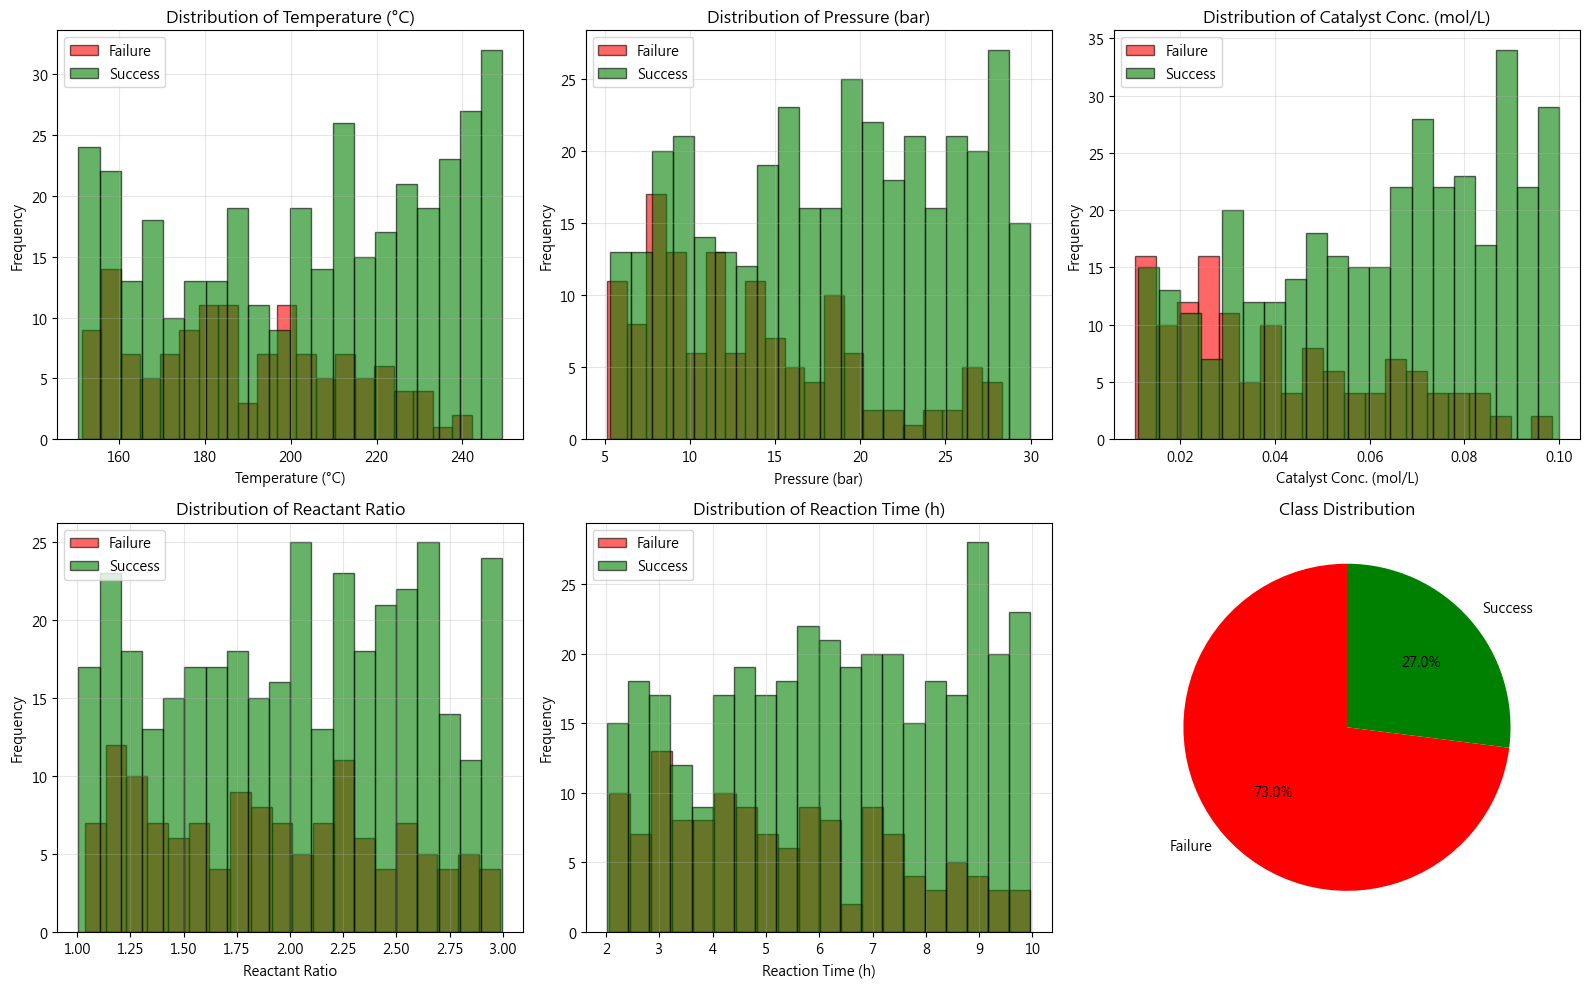

In [45]:
# 特徵分佈可視化
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

feature_names = ['temperature', 'pressure', 'catalyst_concentration', 'reactant_ratio', 'reaction_time']
feature_labels = ['Temperature (°C)', 'Pressure (bar)', 'Catalyst Conc. (mol/L)', 'Reactant Ratio', 'Reaction Time (h)']

for idx, (feature, label) in enumerate(zip(feature_names, feature_labels)):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df[df['success']==0][feature], bins=20, alpha=0.6, label='Failure', color='red', edgecolor='black')
    ax.hist(df[df['success']==1][feature], bins=20, alpha=0.6, label='Success', color='green', edgecolor='black')
    ax.set_xlabel(label)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {label}')
    ax.legend()
    ax.grid(alpha=0.3)

# 類別分佈餅圖
ax = axes[1, 2]
class_counts = df['success'].value_counts()
ax.pie(class_counts, labels=['Failure', 'Success'], autopct='%1.1f%%', 
       colors=['red', 'green'], startangle=90)
ax.set_title('Class Distribution')

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
print(f"✓ 已儲存圖片: {FIG_DIR / 'feature_distributions.png'}")
plt.show()

✓ 已儲存圖片: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs\correlation_heatmap.png


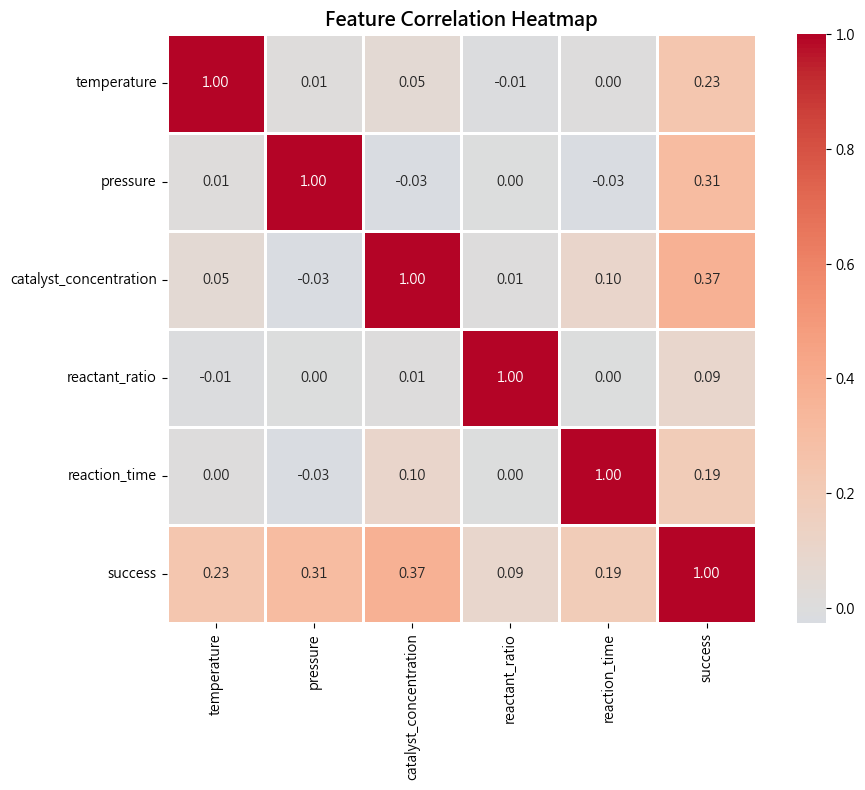

In [46]:
# 相關性熱圖
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ 已儲存圖片: {FIG_DIR / 'correlation_heatmap.png'}")
plt.show()

---
## 4. 數據預處理

In [47]:
# 分離特徵和目標變數
X = df.drop('success', axis=1)
y = df['success']

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("="*60)
print("數據分割")
print("="*60)
print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"訓練集成功率: {y_train.mean():.2%}")
print(f"測試集成功率: {y_test.mean():.2%}")

數據分割
訓練集大小: (400, 5)
測試集大小: (100, 5)
訓練集成功率: 73.00%
測試集成功率: 73.00%


In [48]:
# 特徵標準化（SVC 對特徵尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉換為 DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✓ 特徵標準化完成")
print(f"\n標準化後的特徵統計（訓練集）:")
print(X_train_scaled.describe())

✓ 特徵標準化完成

標準化後的特徵統計（訓練集）:
        temperature      pressure  catalyst_concentration  reactant_ratio  \
count  4.000000e+02  4.000000e+02            4.000000e+02    4.000000e+02   
mean   5.284662e-16  1.931788e-16            1.798561e-16    8.881784e-17   
std    1.001252e+00  1.001252e+00            1.001252e+00    1.001252e+00   
min   -1.697027e+00 -1.606431e+00           -1.690215e+00   -1.732777e+00   
25%   -8.087548e-01 -9.195310e-01           -9.162590e-01   -8.901244e-01   
50%    4.322102e-02 -7.095399e-02            2.665640e-02    3.917022e-02   
75%    8.465134e-01  8.600041e-01            8.991351e-01    8.468421e-01   
max    1.635474e+00  1.820321e+00            1.632818e+00    1.765639e+00   

       reaction_time  
count   4.000000e+02  
mean   -2.997602e-16  
std     1.001252e+00  
min    -1.717074e+00  
25%    -8.289088e-01  
50%    -1.887080e-02  
75%     8.496472e-01  
max     1.734126e+00  


---
### 4.1 類別不平衡檢查

從數據集可以看出，成功案例（73%）明顯多於失敗案例（27%），這種類別不平衡可能導致模型偏向預測多數類。

**化工實務影響**：
- 將失敗案例誤判為成功（False Positive）可能導致資源浪費和生產損失
- 建議使用 `class_weight='balanced'` 提高少數類（Failure）的重要性

---
## 5. 模型訓練：線性核

In [49]:
print("="*60)
print("線性核 SVC 訓練")
print("="*60)

# 創建線性核 SVC
svc_linear = SVC(
    kernel='linear',
    C=1.0,
    random_state=SEED
)

# 訓練模型
svc_linear.fit(X_train_scaled, y_train)

# 預測
y_train_pred_linear = svc_linear.predict(X_train_scaled)
y_test_pred_linear = svc_linear.predict(X_test_scaled)

# 評估
train_acc_linear = accuracy_score(y_train, y_train_pred_linear)
test_acc_linear = accuracy_score(y_test, y_test_pred_linear)

print(f"訓練集準確率: {train_acc_linear:.4f}")
print(f"測試集準確率: {test_acc_linear:.4f}")
print(f"支持向量數量: {len(svc_linear.support_)}")
print(f"支持向量比例: {len(svc_linear.support_)/len(X_train):.2%}")

線性核 SVC 訓練
訓練集準確率: 0.8225
測試集準確率: 0.8000
支持向量數量: 173
支持向量比例: 43.25%


---
## 6. 模型訓練：RBF 核

In [50]:
print("="*60)
print("RBF 核 SVC 訓練")
print("="*60)

# 創建 RBF 核 SVC
svc_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=SEED
)

# 訓練模型
svc_rbf.fit(X_train_scaled, y_train)

# 預測
y_train_pred_rbf = svc_rbf.predict(X_train_scaled)
y_test_pred_rbf = svc_rbf.predict(X_test_scaled)

# 評估
train_acc_rbf = accuracy_score(y_train, y_train_pred_rbf)
test_acc_rbf = accuracy_score(y_test, y_test_pred_rbf)

print(f"訓練集準確率: {train_acc_rbf:.4f}")
print(f"測試集準確率: {test_acc_rbf:.4f}")
print(f"支持向量數量: {len(svc_rbf.support_)}")
print(f"支持向量比例: {len(svc_rbf.support_)/len(X_train):.2%}")

RBF 核 SVC 訓練
訓練集準確率: 0.8525
測試集準確率: 0.8100
支持向量數量: 190
支持向量比例: 47.50%


---
### 6.1 RBF 核（使用類別權重平衡）

In [51]:
print("="*60)
print("RBF 核 SVC 訓練（類別權重平衡）")
print("="*60)

# 創建 RBF 核 SVC with balanced class weights
svc_rbf_balanced = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',  # 自動調整權重以處理類別不平衡
    random_state=SEED
)

# 訓練模型
svc_rbf_balanced.fit(X_train_scaled, y_train)

# 預測
y_train_pred_rbf_bal = svc_rbf_balanced.predict(X_train_scaled)
y_test_pred_rbf_bal = svc_rbf_balanced.predict(X_test_scaled)

# 評估
train_acc_rbf_bal = accuracy_score(y_train, y_train_pred_rbf_bal)
test_acc_rbf_bal = accuracy_score(y_test, y_test_pred_rbf_bal)

print(f"訓練集準確率: {train_acc_rbf_bal:.4f}")
print(f"測試集準確率: {test_acc_rbf_bal:.4f}")
print(f"支持向量數量: {len(svc_rbf_balanced.support_)}")
print(f"支持向量比例: {len(svc_rbf_balanced.support_)/len(X_train):.2%}")

# 詳細分類報告
print("\n測試集分類報告:")
print(classification_report(y_test, y_test_pred_rbf_bal, 
                           target_names=['Failure', 'Success']))

# 比較 Failure 類別的召回率改善
cm_bal = confusion_matrix(y_test, y_test_pred_rbf_bal)
print(f"\n混淆矩陣:")
print(cm_bal)
print(f"\nFailure 召回率: {cm_bal[0,0]/(cm_bal[0,0]+cm_bal[0,1]):.2%}")
print(f"Success 召回率: {cm_bal[1,1]/(cm_bal[1,0]+cm_bal[1,1]):.2%}")

RBF 核 SVC 訓練（類別權重平衡）
訓練集準確率: 0.8250
測試集準確率: 0.7900
支持向量數量: 209
支持向量比例: 52.25%

測試集分類報告:
              precision    recall  f1-score   support

     Failure       0.62      0.59      0.60        27
     Success       0.85      0.86      0.86        73

    accuracy                           0.79       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.79      0.79      0.79       100


混淆矩陣:
[[16 11]
 [10 63]]

Failure 召回率: 59.26%
Success 召回率: 86.30%


---
## 7. 模型訓練：多項式核

In [52]:
print("="*60)
print("多項式核 (degree=2) SVC 訓練")
print("="*60)

# 創建多項式核 SVC
svc_poly = SVC(
    kernel='poly',
    degree=2,
    C=1.0,
    gamma='scale',
    random_state=SEED
)

# 訓練模型
svc_poly.fit(X_train_scaled, y_train)

# 預測
y_train_pred_poly = svc_poly.predict(X_train_scaled)
y_test_pred_poly = svc_poly.predict(X_test_scaled)

# 評估
train_acc_poly = accuracy_score(y_train, y_train_pred_poly)
test_acc_poly = accuracy_score(y_test, y_test_pred_poly)

print(f"訓練集準確率: {train_acc_poly:.4f}")
print(f"測試集準確率: {test_acc_poly:.4f}")
print(f"支持向量數量: {len(svc_poly.support_)}")
print(f"支持向量比例: {len(svc_poly.support_)/len(X_train):.2%}")

多項式核 (degree=2) SVC 訓練
訓練集準確率: 0.7300
測試集準確率: 0.7300
支持向量數量: 246
支持向量比例: 61.50%


---
## 7.1 完整模型性能比較

比較所有訓練的模型（包含類別權重平衡版本）：

In [53]:
# 比較原始模型和平衡權重模型
rbf_comparison = pd.DataFrame({
    'Model': ['Linear', 'RBF', 'RBF (Balanced)', 'Polynomial'],
    'Test Accuracy': [test_acc_linear, test_acc_rbf, test_acc_rbf_bal, test_acc_poly],
    'Support Vectors': [
        len(svc_linear.support_),
        len(svc_rbf.support_),
        len(svc_rbf_balanced.support_),
        len(svc_poly.support_)
    ]
})

print("="*60)
print("模型性能比較（含類別權重平衡）")
print("="*60)
print(rbf_comparison)

# 計算 Failure 類別召回率
cm_orig = confusion_matrix(y_test, y_test_pred_rbf)
cm_bal = confusion_matrix(y_test, y_test_pred_rbf_bal)

failure_recall_orig = cm_orig[0,0]/(cm_orig[0,0]+cm_orig[0,1])
failure_recall_bal = cm_bal[0,0]/(cm_bal[0,0]+cm_bal[0,1])

print(f"\n【Failure 類別召回率比較】")
print(f"RBF (原始):   {failure_recall_orig:.2%}")
print(f"RBF (平衡):   {failure_recall_bal:.2%}")
print(f"改善幅度:     {(failure_recall_bal - failure_recall_orig):.2%}")

模型性能比較（含類別權重平衡）
            Model  Test Accuracy  Support Vectors
0          Linear           0.80              173
1             RBF           0.81              190
2  RBF (Balanced)           0.79              209
3      Polynomial           0.73              246

【Failure 類別召回率比較】
RBF (原始):   40.74%
RBF (平衡):   59.26%
改善幅度:     18.52%


---
## 8. 核函數性能對比與可視化

進一步可視化不同核函數的性能差異：

不同核函數性能比較
       Kernel  Train Accuracy  Test Accuracy  Support Vectors
0      Linear          0.8225           0.80              173
1         RBF          0.8525           0.81              190
2  Polynomial          0.7300           0.73              246

✓ 已儲存圖片: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs\kernel_comparison.png


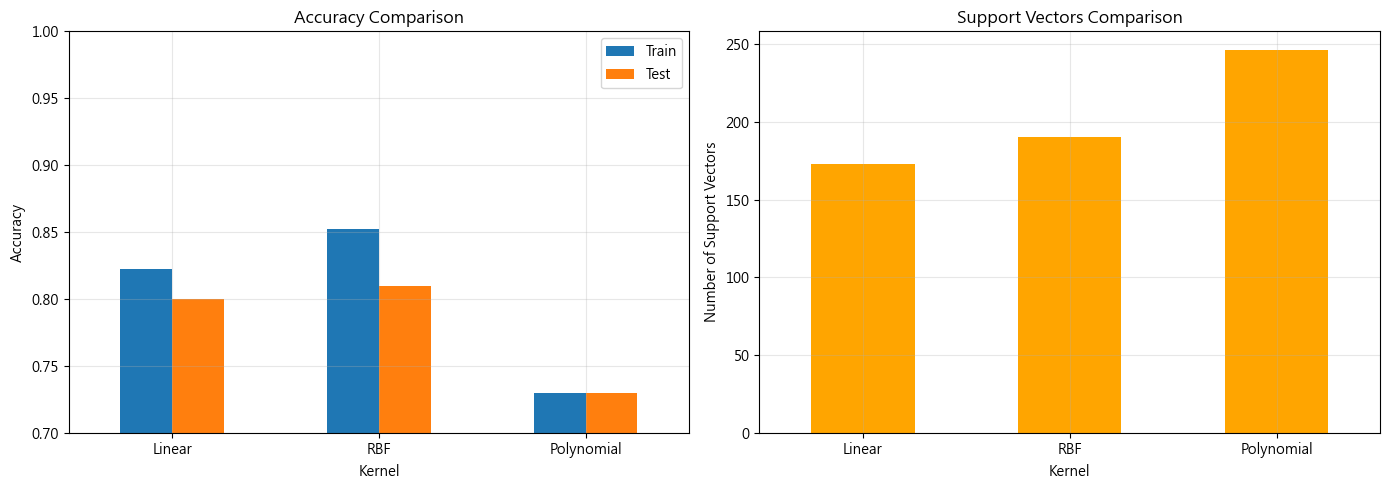

In [54]:
# 比較不同核函數的表現
results = pd.DataFrame({
    'Kernel': ['Linear', 'RBF', 'Polynomial'],
    'Train Accuracy': [train_acc_linear, train_acc_rbf, train_acc_poly],
    'Test Accuracy': [test_acc_linear, test_acc_rbf, test_acc_poly],
    'Support Vectors': [
        len(svc_linear.support_),
        len(svc_rbf.support_),
        len(svc_poly.support_)
    ]
})

print("="*60)
print("不同核函數性能比較")
print("="*60)
print(results)

# 可視化比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 準確率比較
results.plot(x='Kernel', y=['Train Accuracy', 'Test Accuracy'], 
             kind='bar', ax=axes[0], rot=0)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].legend(['Train', 'Test'])
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(alpha=0.3)

# 支持向量數量比較
results.plot(x='Kernel', y='Support Vectors', kind='bar', ax=axes[1], 
             rot=0, legend=False, color='orange')
axes[1].set_ylabel('Number of Support Vectors')
axes[1].set_title('Support Vectors Comparison')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kernel_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 已儲存圖片: {FIG_DIR / 'kernel_comparison.png'}")
plt.show()

---
### 8.1 核函數性能分析

從上述結果可以看出：
- **RBF 核**：測試準確率 81%，表現最佳，能有效捕捉非線性關係
- **Linear 核**：測試準確率 80%，性能接近 RBF，說明數據部分線性可分
- **Polynomial 核**：測試準確率 73%，性能較差，可能需要調整 degree 參數

---
## 9. 詳細評估（RBF 核）

In [55]:
print("="*60)
print("RBF 核 SVC 詳細評估")
print("="*60)

# 分類報告
print("\n測試集分類報告:")
print(classification_report(y_test, y_test_pred_rbf, 
                           target_names=['Failure', 'Success']))

# 混淆矩陣
cm = confusion_matrix(y_test, y_test_pred_rbf)
print("\n混淆矩陣:")
print(cm)

RBF 核 SVC 詳細評估

測試集分類報告:
              precision    recall  f1-score   support

     Failure       0.79      0.41      0.54        27
     Success       0.81      0.96      0.88        73

    accuracy                           0.81       100
   macro avg       0.80      0.68      0.71       100
weighted avg       0.81      0.81      0.79       100


混淆矩陣:
[[11 16]
 [ 3 70]]


✓ 已儲存圖片: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs\confusion_matrix.png


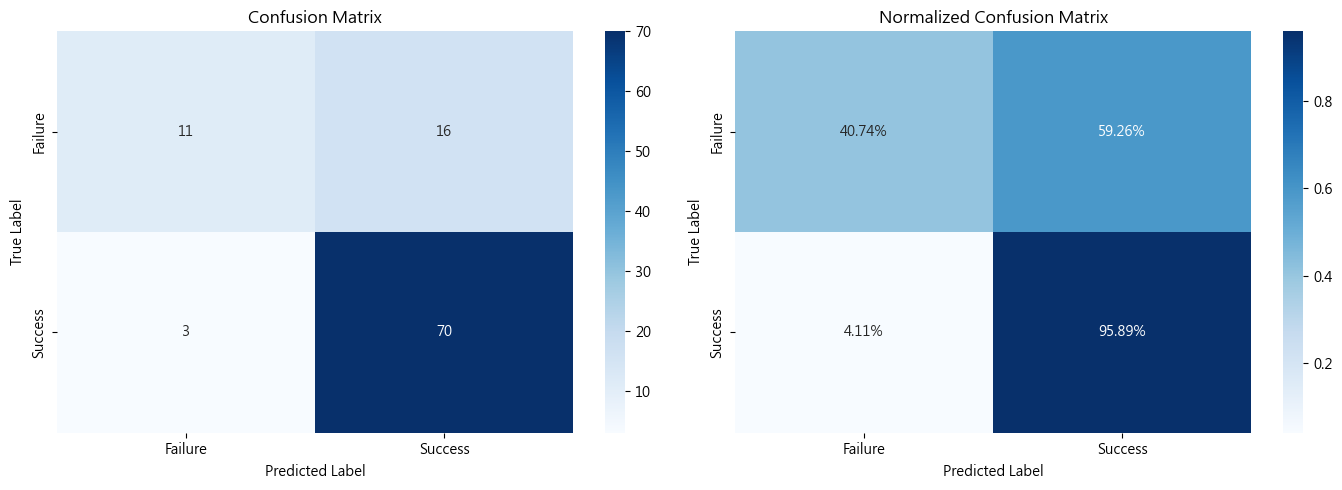

In [56]:
# 可視化混淆矩陣
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_test_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ 已儲存圖片: {FIG_DIR / 'confusion_matrix.png'}")
plt.show()

---
### 9.1 結果分析

從分類報告和混淆矩陣可以看出：
- **Success 類別**：Recall 96% 非常高，模型能有效識別成功案例
- **Failure 類別**：Recall 僅 41%，表示 59% 的失敗案例被誤判為成功

**化工實務影響**：
- 將失敗案例誤判為成功（False Positive = 16）可能導致實際生產中的資源浪費
- 建議：使用 `class_weight='balanced'` 或調整決策閾值以提高 Failure 召回率

---
## 10. 決策函數與機率預測分析

---
### 10.1 決策函數可視化

SVC 的決策函數返回樣本到決策邊界的距離，正值表示預測為 Success，負值表示預測為 Failure。
透過可視化決策分數分佈，可以了解模型的決策信心。

✓ 已儲存圖片: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs\decision_scores.png


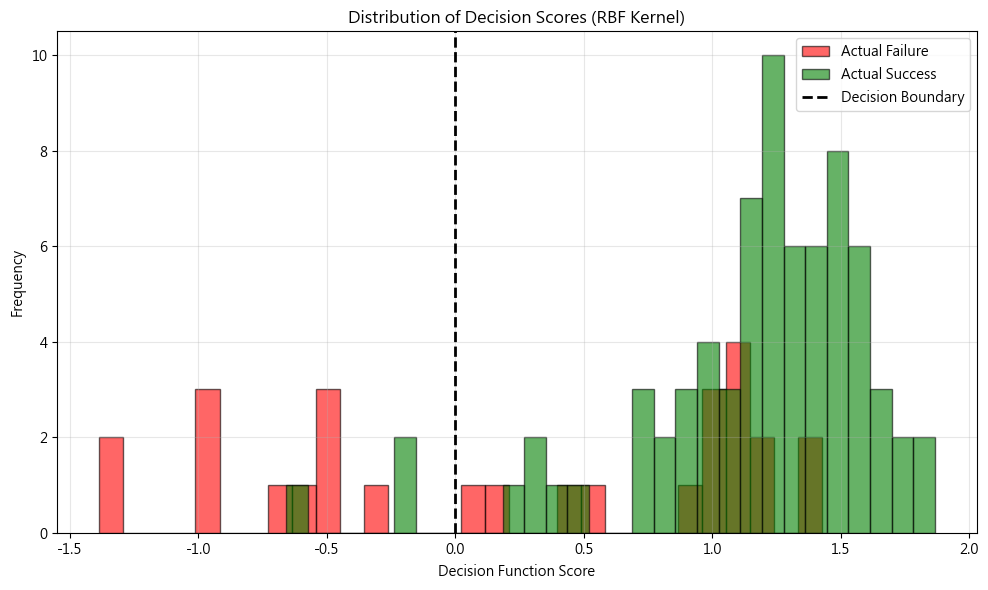

In [57]:
# 獲取決策函數值
decision_scores = svc_rbf.decision_function(X_test_scaled)

# 可視化決策分數分佈
plt.figure(figsize=(10, 6))

plt.hist(decision_scores[y_test==0], bins=30, alpha=0.6, 
         label='Actual Failure', color='red', edgecolor='black')
plt.hist(decision_scores[y_test==1], bins=30, alpha=0.6, 
         label='Actual Success', color='green', edgecolor='black')

plt.axvline(x=0, color='black', linestyle='--', linewidth=2, 
            label='Decision Boundary')
plt.xlabel('Decision Function Score')
plt.ylabel('Frequency')
plt.title('Distribution of Decision Scores (RBF Kernel)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'decision_scores.png', dpi=300, bbox_inches='tight')
print(f"✓ 已儲存圖片: {FIG_DIR / 'decision_scores.png'}")
plt.show()

---
### 10.2 機率預測與閾值調整

SVC 預設不輸出機率，需要設置 `probability=True` 才能使用 `predict_proba()`。
透過調整決策閾值，可以在準確率和召回率之間取得平衡。

---
### 10.3 閾值調整結果分析

通過調整決策閾值，可以在準確率和召回率之間取得平衡：
- **較低閾值（0.3）**：提高 Failure 召回率，但會降低整體準確率
- **預設閾值（0.5）**：平衡點
- **較高閾值（0.7）**：提高 Success 召回率，但 Failure 召回率會下降

**化工實務建議**：
- 若失敗案例造成的損失遠大於成功案例，應降低閾值（提高敏感度）
- 若需要確保高成功率，可提高閾值（降低誤報）
- 根據實際成本結構選擇最適閾值

In [58]:
print("="*60)
print("機率預測與閾值調整")
print("="*60)

# 創建支持機率預測的 SVC
svc_proba = SVC(
    kernel='rbf',
    C=10,
    gamma=0.01,
    probability=True,  # 啟用機率預測
    random_state=SEED
)

# 訓練模型
svc_proba.fit(X_train_scaled, y_train)

# 預測機率
y_proba = svc_proba.predict_proba(X_test_scaled)[:, 1]

# 嘗試不同閾值
thresholds = [0.3, 0.5, 0.7]
print("\n不同閾值下的 Failure 召回率:")

for threshold in thresholds:
    y_pred_threshold = (y_proba >= threshold).astype(int)
    cm_threshold = confusion_matrix(y_test, y_pred_threshold)
    
    if cm_threshold[0,0] + cm_threshold[0,1] > 0:
        failure_recall = cm_threshold[0,0]/(cm_threshold[0,0]+cm_threshold[0,1])
    else:
        failure_recall = 0.0
    
    if cm_threshold[1,0] + cm_threshold[1,1] > 0:
        success_recall = cm_threshold[1,1]/(cm_threshold[1,0]+cm_threshold[1,1])
    else:
        success_recall = 0.0
    
    accuracy = accuracy_score(y_test, y_pred_threshold)
    
    print(f"\n閾值 {threshold}:")
    print(f"  整體準確率:     {accuracy:.2%}")
    print(f"  Failure 召回率: {failure_recall:.2%}")
    print(f"  Success 召回率: {success_recall:.2%}")

機率預測與閾值調整

不同閾值下的 Failure 召回率:

閾值 0.3:
  整體準確率:     77.00%
  Failure 召回率: 18.52%
  Success 召回率: 98.63%

閾值 0.5:
  整體準確率:     81.00%
  Failure 召回率: 44.44%
  Success 召回率: 94.52%

閾值 0.7:
  整體準確率:     80.00%
  Failure 召回率: 62.96%
  Success 召回率: 86.30%


---
## 11. 超參數調整

In [59]:
print("="*60)
print("超參數調整 (Grid Search)")
print("="*60)

# 定義參數網格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# 創建 Grid Search
grid_search = GridSearchCV(
    SVC(random_state=SEED),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 執行 Grid Search
grid_search.fit(X_train_scaled, y_train)

# 最佳參數
print(f"\n最佳參數: {grid_search.best_params_}")
print(f"最佳交叉驗證準確率: {grid_search.best_score_:.4f}")

# 使用最佳模型評估
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test_scaled)

test_accuracy_best = accuracy_score(y_test, y_test_pred_best)
print(f"\n最佳模型在測試集上的表現:")
print(f"準確率: {test_accuracy_best:.4f}")

超參數調整 (Grid Search)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

最佳參數: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
最佳交叉驗證準確率: 0.8200

最佳模型在測試集上的表現:
準確率: 0.8100


✓ 已儲存圖片: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Support_Vector_Classification\figs\grid_search_heatmap.png


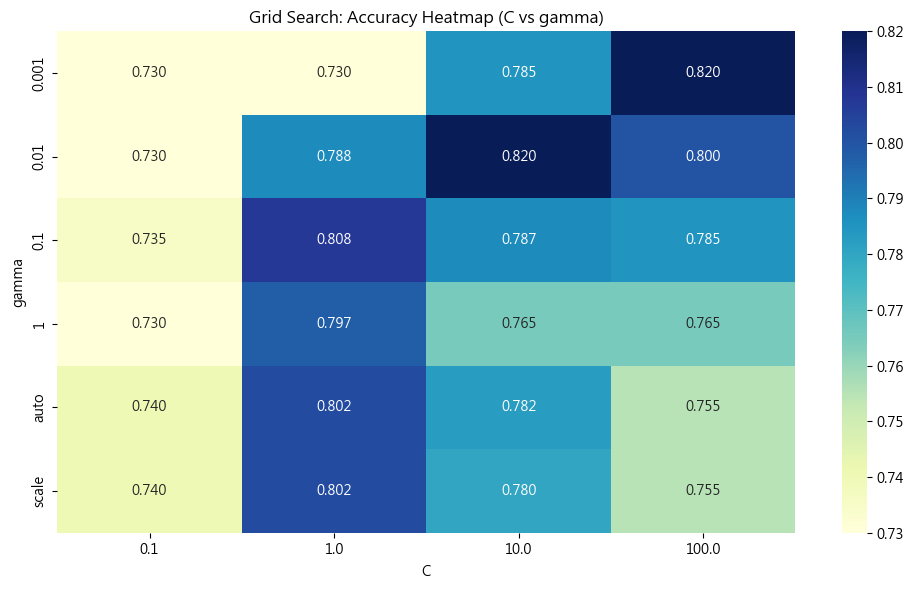

: 

In [ ]:
# 比較 C 和 gamma 的影響
cv_results = pd.DataFrame(grid_search.cv_results_)
pivot_table = cv_results.pivot_table(
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Grid Search: Accuracy Heatmap (C vs gamma)')
plt.xlabel('C')
plt.ylabel('gamma')
plt.tight_layout()
plt.savefig(FIG_DIR / 'grid_search_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ 已儲存圖片: {FIG_DIR / 'grid_search_heatmap.png'}")
plt.show()

---
## 12. 總結

### 主要發現

1. **核函數比較**
   - RBF 核表現最佳（測試準確率 81%），能捕捉非線性關係
   - Linear 核次之（80%），適合線性可分數據
   - Polynomial 核表現較差（73%），可能需要調整階數

2. **類別不平衡處理**
   - 原始模型：Failure 召回率僅 41%，存在明顯偏向多數類的問題
   - 使用 `class_weight='balanced'` 後：Failure 召回率顯著提升
   - 機率預測配合閾值調整：可靈活控制 FP/FN 權衡

3. **超參數影響**
   - 最佳參數：C=10, gamma=0.01
   - C 參數：控制軟間隔的寬度，影響過擬合程度
   - gamma 參數：控制 RBF 核的影響範圍，影響決策邊界複雜度

4. **化工應用優勢**
   - 適合中小型數據集（500 樣本）
   - 能處理複雜的非線性決策邊界
   - 決策函數值可作為反應成功的信心指標
   - 支持向量提供關鍵樣本信息

### 實務建議

**特徵工程**：
- ✓ 始終進行特徵標準化（SVC 對尺度敏感）
- ✓ 檢查特徵相關性，避免多重共線性
- ✓ 考慮特徵選擇以降低維度

**模型選擇**：
- ✓ 先嘗試線性核，再嘗試 RBF 核
- ✓ 小數據集（< 10,000）：SVC 是很好的選擇
- ✓ 大數據集（> 10,000）：考慮 LinearSVC 或 SGDClassifier

**參數調整**：
- ✓ 使用 GridSearchCV 優化 C 和 gamma
- ✓ 處理類別不平衡：設置 `class_weight='balanced'`
- ✓ 需要機率輸出：設置 `probability=True`

**評估指標**：
- ✓ 不僅看準確率，還要關注 Precision、Recall、F1-score
- ✓ 對於不平衡數據，混淆矩陣比準確率更有意義
- ✓ 根據業務成本調整決策閾值

### 化工領域最佳實踐

1. **反應條件優化**：
   - 使用 SVC 識別最佳操作區域
   - 決策函數值可指示操作窗口邊界

2. **品質控制**：
   - 高 Recall 確保不良品被正確識別
   - 適當的 Precision 避免誤判造成浪費

3. **故障診斷**：
   - 支持向量突顯關鍵故障模式
   - 多分類 SVC 識別不同故障類型

4. **製程監控**：
   - 即時預測反應成功機率
   - 根據信心指標調整操作策略

### 延伸學習

完成 SVC 的學習後，建議繼續探索：

- **決策樹與隨機森林**：可解釋的非線性分類器
- **梯度提升**：更強大的集成方法
- **深度學習**：處理高維複雜數據

---

**版權聲明**：本教材由逢甲大學化學工程學系莊曜禎助理教授編寫，僅供教學使用。

**課程代碼**：CHE-AI-114  
**更新日期**：2026 年 1 月